In [1]:
import numpy as np
import pandas as pd
import json
from main_sbm import SBM
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import pickle as pkl
from collections import Counter

In [352]:
def plot_adj_ordered(X, trained_SBM, with_lines = True, my_order = "default"):
    if trained_SBM.unicluster:
        idx_list = np.array([])
        l = []

        if my_order == "default":
            order = range(trained_SBM.z_hat.shape[1])
        else:
            order = my_order
        for i in order:
            idx_list = np.append(idx_list, np.argwhere(trained_SBM.c_hat == i).flatten())
            l.append(len(idx_list))

        X_ordered = X[np.ix_(idx_list.astype(int),idx_list.astype(int))]
        fig, ax = plt.subplots(figsize = (10,10))
        ax = sns.heatmap(X_ordered, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
        if with_lines:
            for i in l:
                plt.axvline(x=i, color = 'r', lw = 0.5)
                plt.axhline(y=i, color = 'r', lw = 0.5)
    else:
        idx_list_rows = np.array([])
        lr = []
        lc = []

        if my_order == "default":
            order_r = range(trained_SBM.zr_hat.shape[1])
            order_c = range(trained_SBM.zc_hat.shape[1])
        else:
            order_r = my_order[0]
            order_c = my_order[1]
        for i in order_r:
            idx_list_rows = np.append(idx_list_rows, np.argwhere(trained_SBM.cr_hat == i).flatten())
            lr.append(len(idx_list_rows))
            #  print(len(np.argwhere(PY.c_hat == i)))

        idx_list_columns = np.array([])
        for i in order_c:
            idx_list_columns = np.append(idx_list_columns, np.argwhere(trained_SBM.cc_hat == i).flatten())
            lc.append(len(idx_list_columns))
        X_ordered = X[np.ix_(idx_list_rows.astype(int),idx_list_columns.astype(int))]
        fig, ax = plt.subplots(figsize = (10,10))
        ax = sns.heatmap(X_ordered, linewidth=0.0, ax = ax, cbar = False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
        if with_lines:
            for i in lr:
                plt.axhline(y = i, color = 'red', lw=0.5)
            for i in lc:
                plt.axvline(x = i, color = 'r', lw=0.5)
    plt.show()

def create_clustering_order(SBM_trained, fill = True):
    if SBM_trained.unicluster:
        l = []
        for i in range(SBM_trained.z_hat.shape[1]):
            cl = np.argwhere(SBM_trained.c_hat == i).flatten()
            temp = df_sen.iloc[cl,:]['lr'].astype(float)
            if fill:
                temp[np.isinf(temp)] = 5
                l.append(temp.mean())
            else:
                l.append(temp[np.isfinite(temp)].mean())
        l = np.array(l)
        return np.argsort(l)
    else:
        lr = []
        for i in range(SBM_trained.zr_hat.shape[1]):
            cl = np.argwhere(SBM_trained.cr_hat == i).flatten()
            temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
            if fill:
                temp[np.isinf(temp)] = 5
                lr.append(temp.mean())
            else:
                lr.append(temp[np.isfinite(temp)].mean())
        lr = np.array(lr)

        lc = []
        for i in range(SBM_trained.zc_hat.shape[1]):
            cl = np.argwhere(SBM_trained.cc_hat == i).flatten()
            temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
            if fill:
                temp[np.isinf(temp)] = 5
                lc.append(temp.mean())
            else:
                lc.append(temp[np.isfinite(temp)].mean())
        lc = np.array(lc)
        return (np.argsort(lr), np.argsort(lc))


In [40]:
with open("datasets/edges_se2013.json") as f:
    df = pd.DataFrame(json.load(f))

df = df.drop(['nfw', 'gsw'], axis=1)

# with open("datasets/senators_2013.json") as f:
#     senators = pd.DataFrame(json.load(f))

In [315]:
# with open("datasets/sen13.json", "wb") as f:
#     pkl.dump(df2, f)

# df2 = df.copy()
# for j in range(df.shape[0]):
#     for i in range(df.shape[1]):
#         df2.iloc[j,i] = df.iloc[j,i][0]

with open("datasets/sen13.json", "rb") as f:
    df_sen = pkl.load(f)

df_sen = df_sen.reset_index(drop=False)
df_sen.rename({'index':'encoding'}, axis=1, inplace=True)
df_sen = df_sen.drop('partyname', axis=1)
for i in range(len(df_sen)):
    if df_sen.iloc[i].loc['party'] == "M5S":
        df_sen.iloc[i,3] = 2.61

In [308]:
df_X = df.merge(df_sen,how="left", left_on = 'i', right_on = 'vertex.names', suffixes = (None, '_i'))
df_X = df_X.merge(df_sen,how="left", left_on = 'j', right_on = 'vertex.names', suffixes = (None, '_j'))

In [287]:
dict(zip(df_sen['party'], df_sen['lr']))

{'NCD': 7.4,
 'NCD-UDC': 6.8,
 'FI-PDL': 7.1,
 'GAL': 6.5,
 'PD': 2.6,
 'IND': 'Inf',
 'MPA': 6.2,
 'LN': 7.8,
 'M5S': 2.6,
 'SC': 6,
 'SEL': 1.3}

In [356]:
Counter(df_sen['party'])

Counter({'NCD': 25,
         'NCD-UDC': 3,
         'FI-PDL': 63,
         'GAL': 13,
         'PD': 117,
         'IND': 30,
         'MPA': 18,
         'LN': 14,
         'M5S': 37,
         'SC': 5,
         'SEL': 7})

In [209]:
Sr = list(Counter(df_sen['party']).values())
Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1
z0 = [np.array(Hr), np.array(Hr)]

In [ ]:
z0

In [197]:
z0 = [np.array(Counter(df_sen['party']).values()), np.array(Counter(df_sen['party']).values())]

In [75]:
N = len(df_sen)
X = np.zeros((N,N))
for i in range(len(df_X)):
    X[df_X.iloc[i,3], df_X.iloc[i,7]] = df_X.iloc[i,2]

In [78]:
X[X>0] = 1

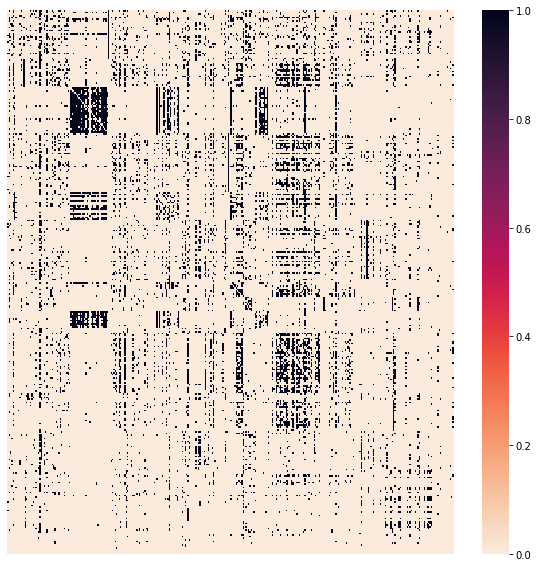

In [79]:
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

SBM

In [80]:
config_uni = {'directed': True,
          'binary': True,
          'unicluster': True}

config_bi = {'directed': True,
          'binary': True,
          'unicluster': False}

In [217]:
PY = SBM(config_uni, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
                # start_z = "singleton",
                 set_seed=42)
PY.fit(X,100)
PY.compute_block_probabilities()
PY.predict()

C:\Users\nakaz\AppData\Local\Temp\ipykernel_12756\1697256623.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if my_order == "default":


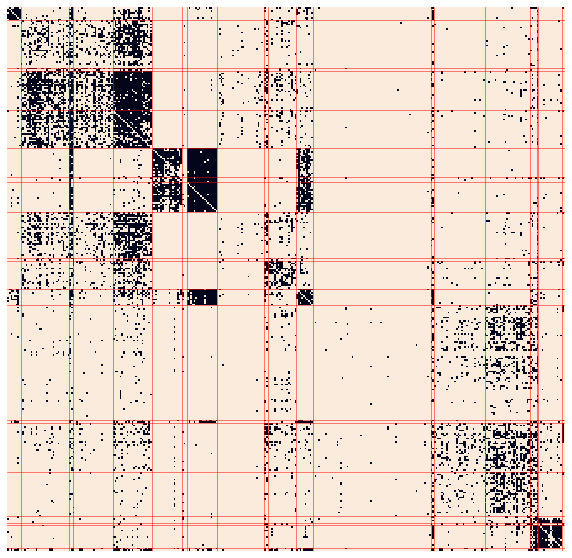

In [368]:
plot_adj_ordered(X,PY, my_order=create_clustering_order(PY, False))

In [147]:
PY_2 = SBM(config_uni, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
                start_z = "singleton", set_seed=42)
PY_2.fit(X,1000)
PY_2.compute_block_probabilities()
PY_2.predict()

In [212]:
PY_2.evalZ(z0)

VI_rel_true:  3.411247308288829
VI_rel_ball:  0.1894231285762462
Kr
0.25:  20.0
0.50:  20.0
0.75:  20.0
Kc
0.25:  20.0
0.50:  20.0
0.75:  20.0


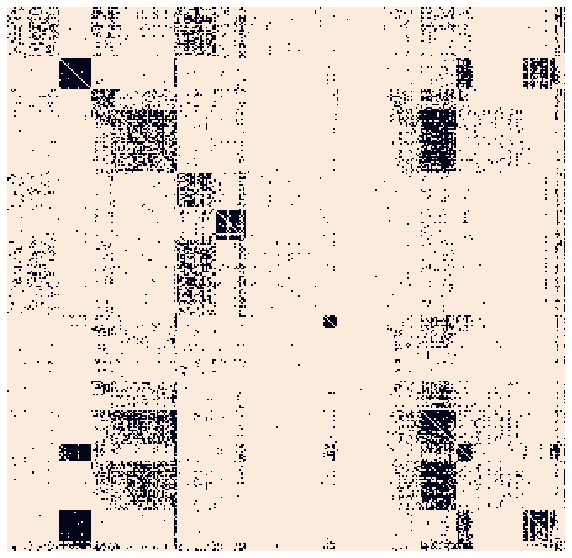

In [82]:
idx_list = np.array([])
for i in range(PY.z_hat.shape[1]):
     idx_list = np.append(idx_list, np.argwhere(PY.c_hat == i).flatten())

X_PY_ordered = X[np.ix_(idx_list.astype(int),idx_list.astype(int))]
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(X_PY_ordered, linewidth=0.0, ax = ax,cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

C:\Users\nakaz\AppData\Local\Temp\ipykernel_12756\1697256623.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if my_order == "default":


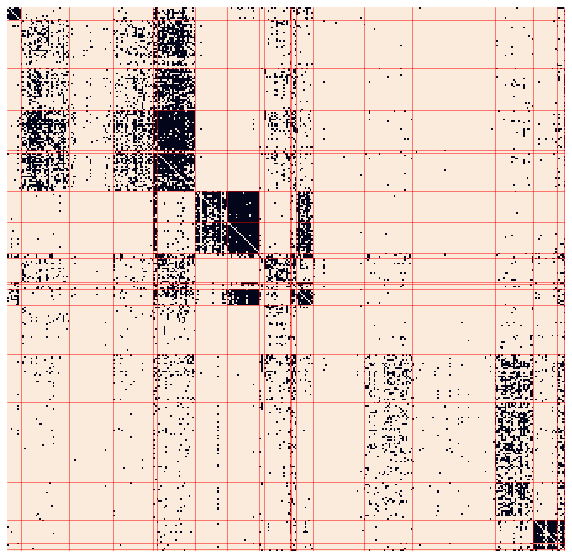

In [370]:
plot_adj_ordered(X,PY_2, my_order=create_clustering_order(PY_2, True))

In [ ]:
for i in range(PY.z_hat.shape[1]):
    print(len(np.argwhere(PY.c_hat == i)))

for i in PY.Z:
     print(PY.evalLogLikelihood_full(i))

In [219]:
PY_bi = SBM(config_bi, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3, 
              #   start_z = "singleton", 
                set_seed=42)
PY_bi.fit(X,100)
PY_bi.compute_block_probabilities()
PY_bi.predict()

In [148]:
PY_bi_2 = SBM(config_bi, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3, 
                start_z = "singleton", set_seed=42)
PY_bi_2.fit(X,1000)
PY_bi_2.compute_block_probabilities()
PY_bi_2.predict()

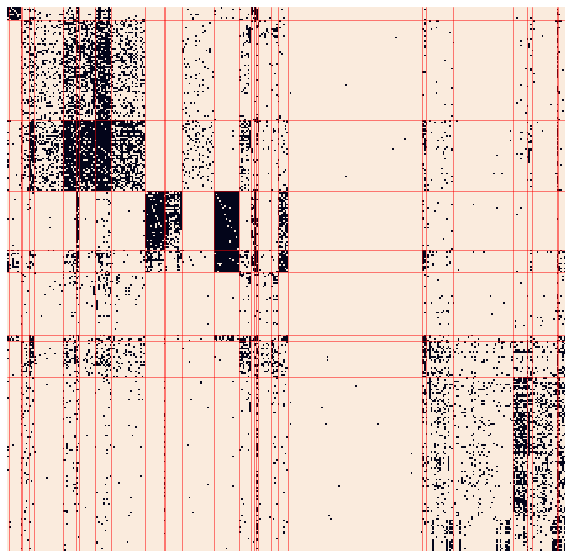

In [373]:
plot_adj_ordered(X,PY_bi_2, my_order=create_clustering_order(PY_bi_2, True))

In [203]:
z0

[[25, 3, 63, 13, 117, 30, 18, 14, 37, 5, 7],
 [25, 3, 63, 13, 117, 30, 18, 14, 37, 5, 7]]

In [211]:
PY_bi_2.evalZ(z0)

VI_rel_true:  3.3297430019155136
VI_rel_ball:  0.3723089218580038
Kr
0.25:  9.0
0.50:  9.0
0.75:  9.0
Kc
0.25:  32.0
0.50:  32.0
0.75:  33.0


In [ ]:
for i, j in zip(PY_bi_2.Zr, PY_bi_2.Zc):
     print(PY_bi_2.evalLogLikelihood_full(i,j))

In [ ]:
for i, j in zip(PY_bi.Zr, PY_bi.Zc):
     print(PY_bi.evalLogLikelihood_full(i,j))

for i in range(PY_bi.zr_hat.shape[1]):
    print(len(np.argwhere(PY_bi.cr_hat == i)))

for i in range(PY_bi.zc_hat.shape[1]):
    print(len(np.argwhere(PY_bi.cc_hat == i)))

In [ ]:
for i in range(PY_bi.zr_hat.shape[1]):
    print(len(np.argwhere(PY_bi.cr_hat == i)))

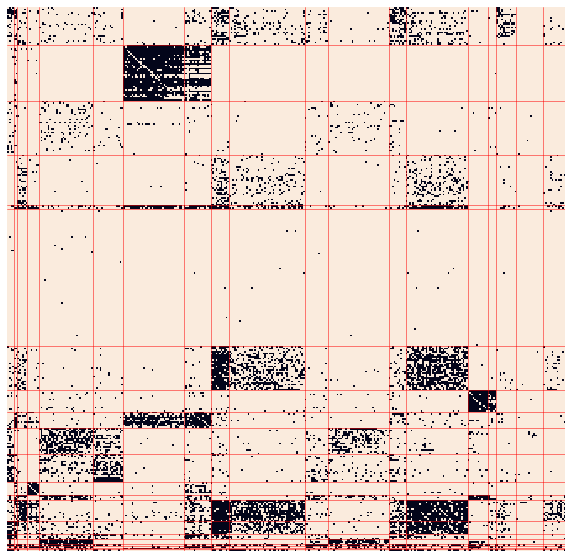

In [185]:
plot_adj_ordered(X.T, PY_bi)

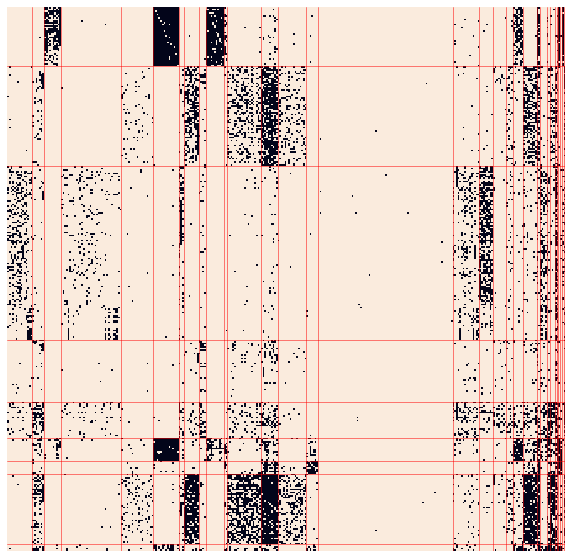

In [186]:
plot_adj_ordered(X, PY_bi_2)

GN

PY = SBM(config_uni, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
                start_z = "singleton", set_seed=42)
PY.fit(X,100)
PY.compute_block_probabilities()
PY.predict()

In [152]:
GN = SBM(config_uni, prior_r = "GN", gamma_GN_r=0.45,
            start_z = "singleton", set_seed=42)
GN.fit(X,1000)
GN.compute_block_probabilities()
GN.predict()


In [ ]:
for i in range(GN.z_hat.shape[1]):
    print(len(np.argwhere(GN.c_hat == i)))

for i in GN.Z:
     print(GN.evalLogLikelihood_full(i))

In [ ]:
for i in range(GN.z_hat.shape[1]):
    cl = np.argwhere(GN.c_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    print(np.mean(temp[np.isfinite(temp)]))

In [361]:
cl = np.argwhere(GN.c_hat == 5).flatten()
df_sen.iloc[cl,:]

,encoding,vertex.names,party,lr
25,25,Antonio RAZZI,FI-PDL,7.1
27,27,Francesco Maria AMORUSO,FI-PDL,7.1
89,89,Vincenzo GIBIINO,FI-PDL,7.1
130,130,Marco MARIN,FI-PDL,7.1
132,132,Maria Elisabetta ALBERTI CASELLATI,FI-PDL,7.1
135,135,Giacomo CALIENDO,FI-PDL,7.1
140,140,Ciro FALANGA,IND,Inf
142,142,Augusto MINZOLINI,FI-PDL,7.1
143,143,Donato BRUNO,FI-PDL,7.1
149,149,Mariarosaria ROSSI,FI-PDL,7.1


In [365]:
l = []
for i in range(GN.z_hat.shape[1]):
    cl = np.argwhere(GN.c_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    # print(np.mean(temp[np.isfinite(temp)]))
    l.append(temp[np.isfinite(temp)].mean())
l = np.array(l)
l

array([2.6       , 2.61      , 4.73333333, 2.6       , 2.6       ,
       7.12727273, 7.8       , 7.375     , 1.95      , 7.12195122,
       7.1       , 5.76428571, 2.6       , 5.602     , 2.6       ,
       2.61      , 2.61      , 5.2       , 7.4       ,        nan])

In [362]:
l = []
for i in range(GN.z_hat.shape[1]):
    cl = np.argwhere(GN.c_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
    temp[np.isinf(temp)] = 5
    l.append(temp.mean())
l = np.array(l)

In [363]:
np.argsort(l)

array([ 8, 12,  0,  3,  4, 14, 15,  1, 16,  2, 19, 17, 13, 11, 10,  9,  5,
        6,  7, 18], dtype=int64)

In [330]:
np.sort(l)

array([1.95      , 2.6       , 2.6       , 2.6       , 2.6       ,
       2.6       , 2.61      , 2.61      , 2.61      , 4.73333333,
       5.2       , 5.602     , 5.76428571, 7.1       , 7.12195122,
       7.12727273, 7.375     , 7.4       , 7.8       ,        nan])

C:\Users\nakaz\AppData\Local\Temp\ipykernel_12756\1697256623.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if my_order == "default":


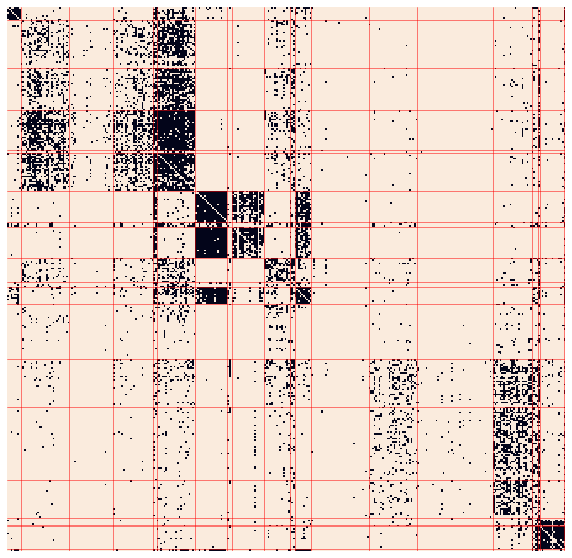

In [366]:
plot_adj_ordered(X, GN, my_order = np.argsort(l))

C:\Users\nakaz\AppData\Local\Temp\ipykernel_12756\2461532582.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if my_order == "default":


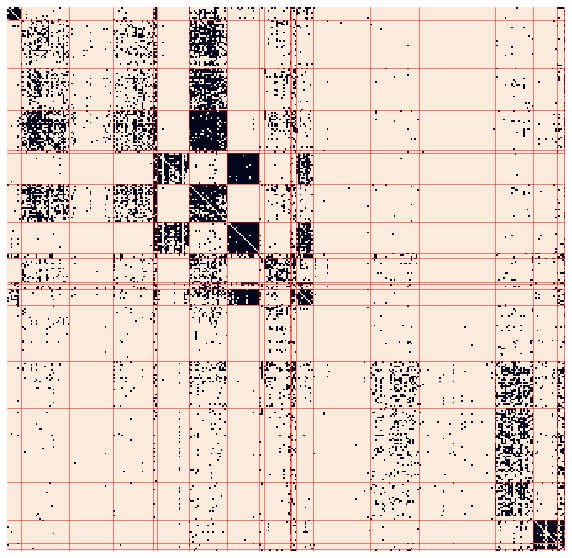

In [277]:
plot_adj_ordered(X, GN, my_order = np.argsort(l))

In [ ]:
cl = np.argwhere(GN.c_hat == 5).flatten()
temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
temp[np.isinf(temp)] = 5
print(temp)

In [235]:
cl = np.argwhere(GN.c_hat == 0).flatten()
temp = df_sen.iloc[cl,:]['lr'].astype(float)
np.mean(temp[np.isfinite(temp)])

2.5999999999999996

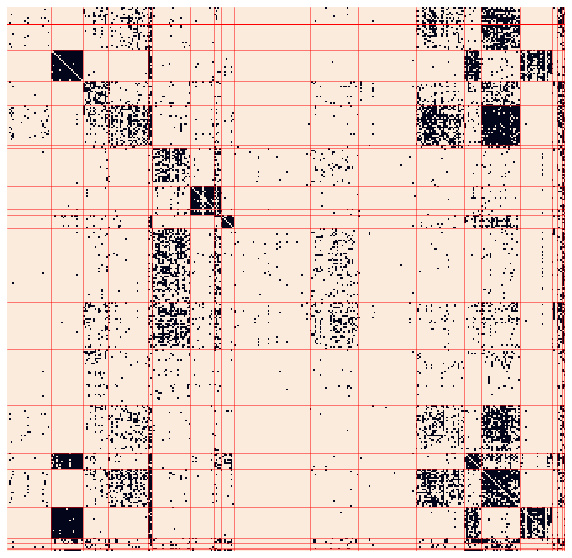

In [172]:
idx_list = np.array([])
l = []
for i in range(GN.z_hat.shape[1]):
     idx_list = np.append(idx_list, np.argwhere(GN.c_hat == i).flatten())
     l.append(len(idx_list))

X_GN_ordered = X[np.ix_(idx_list.astype(int),idx_list.astype(int))]
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(X_GN_ordered, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
for i in l:
     plt.axvline(x=i, color = 'r', lw = 0.5)
     plt.axhline(y=i, color = 'r', lw = 0.5)
plt.show()

In [174]:
GN_bi = SBM(config_bi,  prior_r = "GN", gamma_GN_r=0.45,
          prior_c = "GN", gamma_GN_c=0.45,
                start_z = "singleton", set_seed=42)
GN_bi.fit(X.T,200)
GN_bi.compute_block_probabilities()
GN_bi.predict()

In [385]:
GN_bi_3 = SBM(config_bi,  prior_r = "GN", gamma_GN_r=0.30,
          prior_c = "GN", gamma_GN_c=0.80,
            #     start_z = "singleton", 
                set_seed=42)
GN_bi_3.fit(X,1000)
GN_bi_3.compute_block_probabilities()
GN_bi_3.predict()

In [153]:
GN_bi_2 = SBM(config_bi,  prior_r = "GN", gamma_GN_r=0.45,
          prior_c = "GN", gamma_GN_c=0.45,
                start_z = "singleton", set_seed=42)
GN_bi_2.fit(X,1000)
GN_bi_2.compute_block_probabilities()
GN_bi_2.predict()

In [355]:
GN_bi_T = SBM(config_bi,  prior_r = "GN", gamma_GN_r=0.45,
          prior_c = "GN", gamma_GN_c=0.45,
                start_z = "singleton", set_seed=42)
GN_bi_T.fit(X.T,200)
GN_bi_T.compute_block_probabilities()
GN_bi_T.predict()


In [346]:
lr = []
for i in range(GN_bi_2.zr_hat.shape[1]):
    cl = np.argwhere(GN_bi_2.cr_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
    # temp[np.isinf(temp)] = 5
    # lr.append(temp.mean())
    lr.append(temp[np.isfinite(temp)].mean())
lr = np.array(lr)
lr

array([2.61      , 2.6       , 7.22040816, 5.49      , 4.48421053,
       6.48947368, 1.58888889])

In [347]:
lc = []
for i in range(GN_bi_2.zc_hat.shape[1]):
    cl = np.argwhere(GN_bi_2.cc_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float).copy()
    # temp[np.isinf(temp)] = 5
    # lc.append(temp.mean())
    lc.append(temp[np.isfinite(temp)].mean())
lc = np.array(lc)
lc

array([7.2       , 2.61      , 6.99411765, 5.9       , 2.60055556,
       2.61      , 4.97777778, 2.61      , 5.602     , 2.6       ,
       2.6       , 2.6       , 2.6       , 3.4875    , 7.27826087,
       5.653     , 2.6       , 7.00785714, 7.1       , 2.04285714,
       1.3       , 7.525     , 6.8       ,        nan, 2.6       ,
       4.4       , 7.4       ,        nan, 2.61      ])

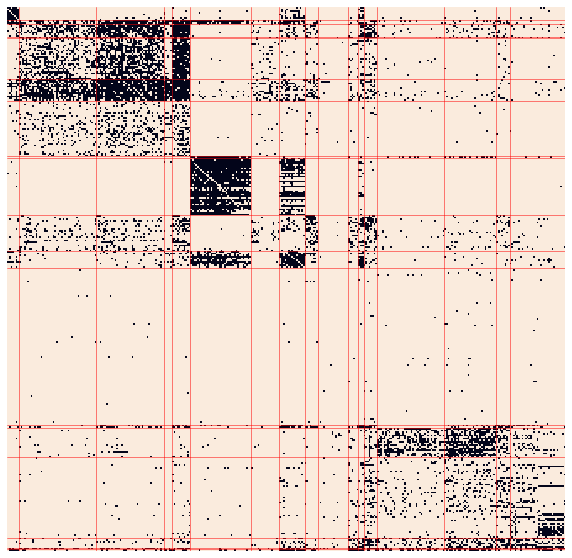

In [359]:
plot_adj_ordered(X.T, GN_bi_T, my_order = create_clustering_order(GN_bi_T, False))

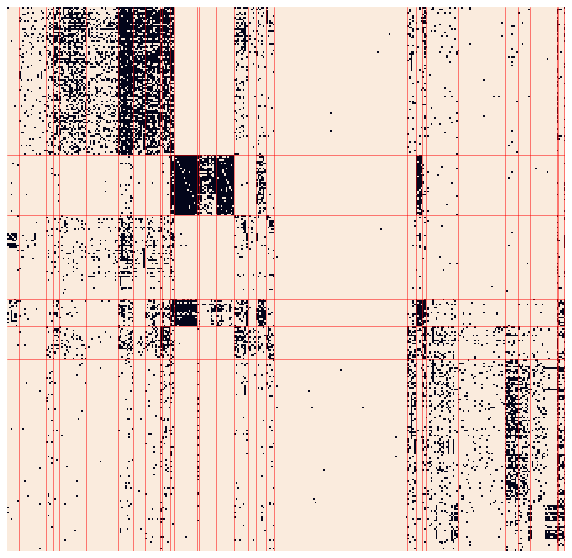

In [354]:
plot_adj_ordered(X, GN_bi, my_order = create_clustering_order(GN_bi, False))

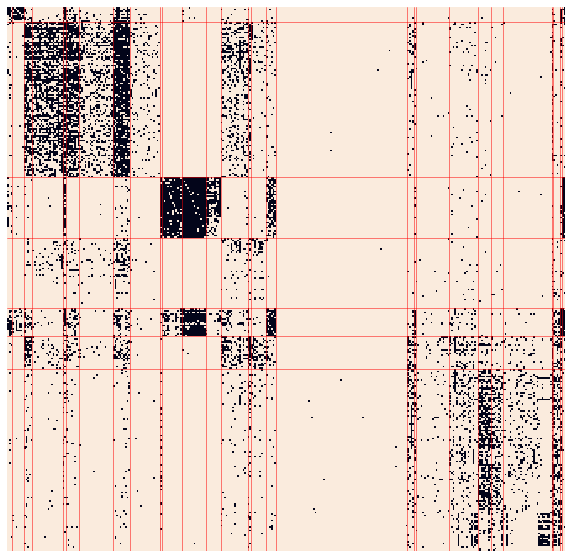

In [374]:
plot_adj_ordered(X, GN_bi_2, my_order = create_clustering_order(GN_bi_2, False))

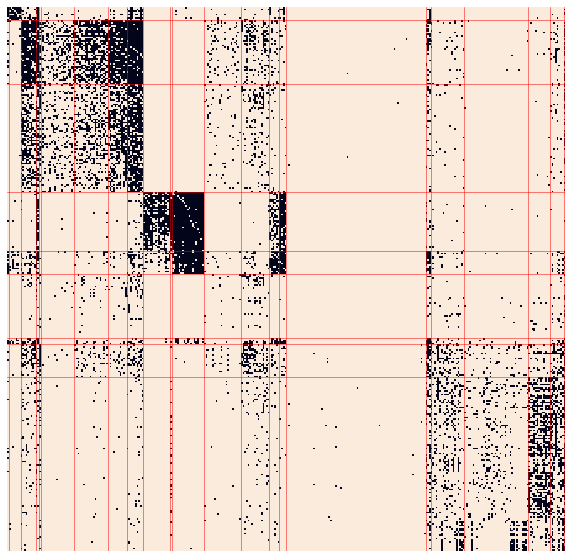

In [386]:
plot_adj_ordered(X, GN_bi_3, my_order = create_clustering_order(GN_bi_3, True))

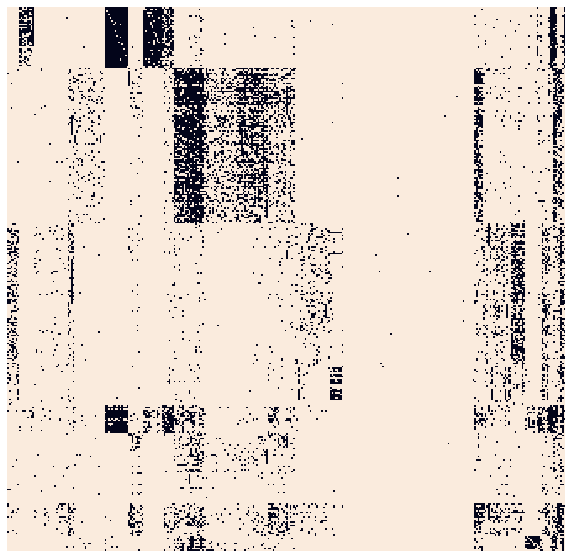

In [154]:
idx_list_rows = np.array([])
lr = []
lc = []
for i in range(GN_bi_2.zr_hat.shape[1]):
     idx_list_rows = np.append(idx_list_rows, np.argwhere(GN_bi_2.cr_hat == i).flatten())
     lr.append(len(idx_list_rows))
    #  print(len(np.argwhere(PY.c_hat == i)))

idx_list_columns = np.array([])
for i in range(GN_bi_2.zc_hat.shape[1]):
     idx_list_columns = np.append(idx_list_columns, np.argwhere(GN_bi_2.cc_hat == i).flatten())
     lc.append(len(idx_list_columns))
     
X_GN_bi_2_ordered = X[np.ix_(idx_list_rows.astype(int),idx_list_columns.astype(int))]
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(X_GN_bi_2_ordered, linewidth=0.0, ax = ax, cbar = False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
for i in lr:
     plt.axhline(y = i, color = 'red', lw=0.5)
for i in lc:
     plt.axvline(x = i, color = 'r', lw=0.5)
plt.show()

In [105]:
for i, j in zip(GN_bi.Zr, GN_bi.Zc):
     print(GN_bi.evalLogLikelihood_full(i,j))

-21675.42913117051
-20481.14819815369
-20238.617095684203
-20075.282137802787
-19742.93058113293
-19656.003389669582
-19510.89284719519
-19162.714229817426
-19132.89832011275
-19116.18404018314
-19106.90690826706
-19104.22316569091
-19028.596421211478
-18851.69154918548
-18697.64235278052
-18684.30001556825
-18679.73458624298
-18681.18261663359
-18682.65089569708
-18672.79827616769
-18657.753525210483
-18676.40632960017
-18679.686627183644
-18678.425051385384
-18670.082403154513
-18671.651413839918
-18661.396718421936
-18647.538793527336
-18670.769630474562
-18660.825723477214
-18663.486017481155
-18677.495518173928
-18670.052025723824
-18645.427938295372
-18652.817797128315
-18651.827213836157
-18648.172250593332
-18667.837610578077
-18653.940103240857
-18655.744419994586
-18638.474744107716
-18662.34281906885
-18661.096258880563
-18657.56091522195
-18657.988827609162
-18647.418799131723
-18659.128675488428
-18645.320409896776
-18641.96862889934
-18649.457446468215
-18657.337179568123

Cluster analysis

In [225]:
for i in range(GN.z_hat.shape[1]):
    cl = np.argwhere(GN.c_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    print(np.mean(temp[np.isfinite(temp)]))

2.5999999999999996
2.6
4.733333333333333
2.6
2.6
7.127272727272725
7.8
7.375
1.9500000000000002
7.121951219512195
7.1000000000000005
5.764285714285714
2.599999999999999
5.6
2.6000000000000005
2.6
2.6
5.2
7.4
nan


In [227]:
for i in range(GN_bi_2.zr_hat.shape[1]):
    cl = np.argwhere(GN_bi_2.cr_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    print(np.mean(temp[np.isfinite(temp)]))

2.5999999999999996
2.6
7.220408163265306
5.487500000000001
4.48421052631579
6.489473684210527
1.5888888888888888


In [229]:
for i in range(GN_bi_2.zc_hat.shape[1]):
    cl = np.argwhere(GN_bi_2.cc_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    print(np.mean(temp[np.isfinite(temp)]))

7.2
2.6
6.9941176470588236
5.9
2.6
2.6000000000000005
4.977777777777778
2.6000000000000005
5.6
2.6
2.6000000000000005
2.6000000000000005
2.6
3.4875
7.2782608695652184
5.652857142857144
2.6
7.007142857142855
7.1000000000000005
2.042857142857143
1.3
7.5249999999999995
6.8
nan
2.6
4.4
7.4
nan
2.6


In [224]:
for i in range(PY.z_hat.shape[1]):
    cl = np.argwhere(PY.c_hat == i).flatten()
    temp = df_sen.iloc[cl,:]['lr'].astype(float)
    print(np.mean(temp[np.isfinite(temp)]))

7.8
2.721428571428571
7.159999999999999
2.6000000000000005
6.618032786885246
2.6000000000000005
1.9500000000000002
2.6
7.375
2.6
2.6
2.599999999999999
5.6
7.0760000000000005
4.905882352941177
4.4
2.6
nan
6.8
7.4


In [132]:
for i in range(PY_bi.zr_hat.shape[1]):
    cl = np.argwhere(PY_bi.cr_hat == i).flatten()
    print(df_sen.iloc[cl,:])

     encoding             vertex.names party   lr
47         47        Gianluca CASTALDI   M5S  2.6
48         48            Elena FATTORI   M5S  2.6
50         50       Ornella BERTOROTTA   M5S  2.6
51         51           Stefano LUCIDI   M5S  2.6
52         52             Sara PAGLINI   M5S  2.6
53         53      Michela MONTEVECCHI   M5S  2.6
54         54            Paola TAVERNA   M5S  2.6
55         55         Elisa BULGARELLI   M5S  2.6
56         56            Marco SCIBONA   M5S  2.6
57         57         Giovanna MANGILI   M5S  2.6
59         59      Rosetta Enza BLUNDO   M5S  2.6
60         60           Vilma MORONESE   M5S  2.6
61         61             Luigi GAETTI   M5S  2.6
62         62             Paola NUGNES   M5S  2.6
63         63      Maurizio BUCCARELLA   M5S  2.6
64         64            Sergio PUGLIA   M5S  2.6
65         65             Bruno MARTON   M5S  2.6
67         67        Giuseppe VACCIANO   IND  Inf
68         68            Manuela SERRA   M5S  2.6


In [146]:
cl = np.argwhere(PY_bi.cr_hat == 3).flatten()
print(df_sen.iloc[cl,:])

     encoding            vertex.names    party   lr
31         31             Karl ZELLER      MPA  6.2
43         43            Fausto LONGO      MPA  6.2
80         80           Pietro ICHINO       PD  2.6
98         98       Stefania GIANNINI       PD  2.6
100       100         Angela D'ONGHIA       SC    6
108       108   Renato Guerino TURANO       PD  2.6
110       110     Maria Paola MERLONI      MPA  6.2
165       165        Luciano PIZZETTI       PD  2.6
199       199        Riccardo NENCINI      MPA  6.2
238       238         Roberta PINOTTI       PD  2.6
243       243           Marco MINNITI       PD  2.6
248       248         Filippo BUBBICO       PD  2.6
255       255          Ignazio MARINO       PD  2.6
256       256          Nicola LATORRE       PD  2.6
280       280          Maurizio ROSSI      IND  Inf
286       286         Renato SCHIFANI   FI-PDL  7.1
295       295          Andrea OLIVERO      MPA  6.2
304       304             Mario MONTI      IND  Inf
305       30

In [120]:
df_sen[df_sen['party'] == 'M5S']

,encoding,vertex.names,party,lr
14,14,Serenella FUCKSIA,M5S,2.6
47,47,Gianluca CASTALDI,M5S,2.6
48,48,Elena FATTORI,M5S,2.6
50,50,Ornella BERTOROTTA,M5S,2.6
51,51,Stefano LUCIDI,M5S,2.6
52,52,Sara PAGLINI,M5S,2.6
53,53,Michela MONTEVECCHI,M5S,2.6
54,54,Paola TAVERNA,M5S,2.6
55,55,Elisa BULGARELLI,M5S,2.6
56,56,Marco SCIBONA,M5S,2.6
